# Statoil/C-CORE Iceberg Classifier Challenge
* * *

## Ship or iceberg, can you decide from space?


## 목차
- 개요
- Background 간략 설명
- 데이터 설명
- 데이터 분석
- 접근법
- 모델

## 개요

> 떠내려오는 빙상은 항해와 활동에 위협이 된다. 현재에는 항공 정찰과 해안 기반 지원을 통하여 환경 상황(빙상)을 감시할 수 있지만 날씨가 험한 오지에서는 위와 같은 방법들은 사용할 수 없으며, 유일한 방법은 위성을 통한 감시 뿐이다. <br><br>
국제 에너지 회사인 Statoil은 가능한 한 빨리 빙산을 더 정확하게 탐지하고 차별하기 위해 기계 학습을 사용하는 방법에 대한 새로운 관점을 얻는 데 관심이 있다. <br><br>
이 Competition 에서는 배인지 빙산인지 자동으로 식별하는 알고리즘을 구축해야 한다. =

## Background 간략 설명

Sentinel-1 위성은 육지와 바다를 감시하는데 사용된다. 이 위성은 어둠, 비, 그림, 안개를 볼 수 있어서 밤낮으로 이미지를 캡처할 수 있다.
물체가 주변보다 더 많은 레이더 에너지를 반사하기 때문에 밝은 지점으로 나타나지만 주변 장애물에서도 많은 레이더 에너지가 나올 수 있다. <br><br>

레이더가 물체를 감지할 때, 반사되는 에너지를 백스캐터라 하는데 이 것만으로는 빙산을 구별할 수 없다. 그러므로 모양, 크기, 밝기 등 특정한 특징들을 더욱 분석해야할 필요가 있다. 이 경우, 물체를 둘러싼 영역을 분석하거나 모델링할 수 있다.

많은 것들이 백스캐터에 영향을 끼친다. 강풍은 밝은 배경을 만들어 내고 반대는 어두운 배경을 만든다.

Sentinel-1 위성은 side looking rader로 이미지 영역을 각도(incidence angle: 입사각)로 보는 것을 의미한다.

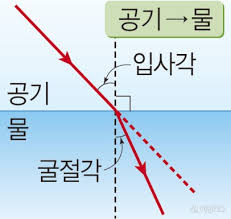

일반적으로, 해양 배경은 더 높은 발생 각도에서 더 어두워질 것이다. Sentinel-1은 수평면과 수직면에서 송신하고 수신할 수 있으며, 이것은 dual-polarization(이중극화) 이미지를 얻을 수 있다.

이 대회에서 HH와 HV의 채널을 볼 수 있으며, 두 채널은 객체의 특성에 중요한 역할을 할 수 있다.
![iceberg](https://storage.googleapis.com/kaggle-media/competitions/statoil/8ZkRcp4.png) 
![ship](https://storage.googleapis.com/kaggle-media/competitions/statoil/M8OP2F2.png)

## 사전 작업들

In [1]:
import os

In [2]:
cur_path = os.getcwd()

In [3]:
file_path = '/kaggle/statoil-iceberg-classifier-challenge'

In [4]:
cur_path + file_path

'/home/gunmo/git/jupyters/kaggle/statoil-iceberg-classifier-challenge'

## 데이터 설명

In [5]:
!ls ./

 Lets_try_the_functools.ipynb
 Lets_try_the_itertools.ipynb
 Lets_try_the_operator.ipynb
'[KAGGLE]Statoil_C-CORE Iceberg Classifier Challenge.ipynb'
 classmethod와staticmethod.ipynb
 kaggle
 matplotlib_Introductory.ipynb
'python magic_method.ipynb'
 stinkbug.png


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [7]:
train = pd.read_json(cur_path + file_path + '/train.json')
test = pd.read_json(cur_path + file_path + '/test.json')
sample = pd.read_csv(cur_path + file_path + '/sample_submission.csv')

In [8]:
print(train.keys())
print(test.keys())

Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'], dtype='object')
Index(['id', 'band_1', 'band_2', 'inc_angle'], dtype='object')


In [9]:
sample.head(4)

,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5
2,b20200e4,0.5
3,e7f018bb,0.5


## 데이터 분석

--- 데이터 ---
각도에 따라 이미지의 밝기가 다르다. -> 밝기 조절 <br>
회전을 통한 이미지 추가 생성 가능 <br>
특정 입사각의 경우 HH, HV 값이 다양합니다. -> 모든 경우에 대해서는? <br>
노이즈 데이터 넣어도 좋을 듯. <br>

1. RAW_DATA
2. NORMALIZE
3. ANGLE
4. ROTATION
5. NOISE

In [10]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [11]:
X_band_1.shape, X_band_2.shape, X_train.shape

((1604, 75, 75), (1604, 75, 75), (1604, 75, 75, 3))

In [12]:
RAW_DATA = X_train.copy()

In [13]:
def normalize(d):
    # d is a (n x dimension) np array
    d -= np.min(d, axis=0)
    d /= np.ptp(d, axis=0)
    return d
NORMALIZE = normalize(X_train.copy())

In [14]:
NORMALIZE.max(), NORMALIZE.min()

(1.0, 0.0)

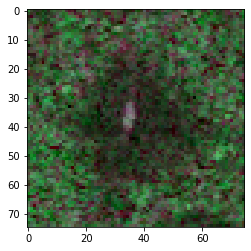

In [15]:
plt.imshow(NORMALIZE[0])

In [16]:
train["id"].head() # string 값

0    dfd5f913
1    e25388fd
2    58b2aaa0
3    4cfc3a18
4    271f93f4
Name: id, dtype: object

In [17]:
len(set(train['inc_angle'].to_list()))

879

In [18]:
sum(train['is_iceberg'] == 1), sum(train['is_iceberg'] == 0) # iceberg: 753, ship: 851

(753, 851)

In [19]:
np.max(X_train[1])
# plt.imshow(X_train[0])

12.570409

## 모델

In [20]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

Using TensorFlow backend.
/home/gunmo/anaconda3/envs/yolov3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gunmo/anaconda3/envs/yolov3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gunmo/anaconda3/envs/yolov3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gunmo/anaconda3/e

In [21]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    # gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
model_path = cur_path + file_path + "/model_weights.hdf5"
callbacks = get_callbacks(filepath=model_path, patience=5)

In [22]:
target_train = train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state = 1, train_size = 0.75)

In [23]:
def train_base_helper(X_DATA):
    target_train = X_DATA['is_iceberg']
    callbacks = get_callbacks(filepath=model_path, patience=5)
    X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state = 1, train_size = 0.75)
    gmodel = getModel()
    gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

In [24]:
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1203 samples, validate on 401 samples
Epoch 1/50


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
	 [[metrics/acc/Mean_1/_161]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [25]:
train_base_helper(NORMALIZE)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices